In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.neural_network import MLPClassifier as MLP

In [76]:
def generate_imbalanced_gaussian(major_size=50000, minor_size=1000, random_seed=1234):
    major_mean = [0., 0.]
    major_cov = [[1., 0.], [0., 1.]]
    np.random.seed(random_seed)
    major_x = np.random.multivariate_normal(major_mean, major_cov, size=major_size)
    major_y = np.zeros(len(major_x))
    minor_mean = [2., 0.]
    minor_cov = [[1., 0.], [0., 1.]]
    np.random.seed(random_seed)
    minor_x = np.random.multivariate_normal(minor_mean, minor_cov, size=minor_size)
    minor_y = np.ones(len(minor_x))
    return major_x, major_y, minor_x, minor_y

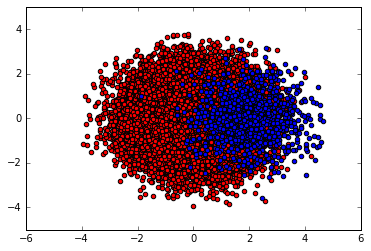

In [77]:
# Generate training data
train_major_x, train_major_y, train_minor_x, train_minor_y = generate_imbalanced_gaussian(random_seed=1234)
train_x = np.concatenate([train_major_x, train_minor_x], axis=0)
train_y = np.concatenate([train_major_y, train_minor_y], axis=0)
plt.scatter(train_major_x[:, 0], train_major_x[:, 1], c='r')
plt.scatter(train_minor_x[:, 0], train_minor_x[:, 1], c='b')
plt.show()

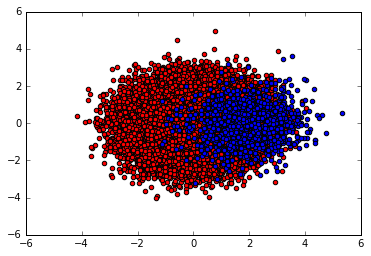

In [78]:
# Generate validation data
valid_major_x, valid_major_y, valid_minor_x, valid_minor_y = generate_imbalanced_gaussian(random_seed=1235)
plt.scatter(valid_major_x[:, 0], valid_major_x[:, 1], c='r')
plt.scatter(valid_minor_x[:, 0], valid_minor_x[:, 1], c='b')
plt.show()
valid_x = np.concatenate([valid_major_x, valid_minor_x], axis=0)
valid_y = np.concatenate([valid_major_y, valid_minor_y], axis=0)

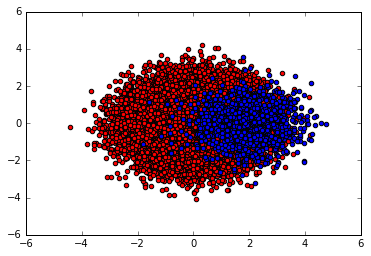

In [79]:
# Generate testing data
test_major_x, test_major_y, test_minor_x, test_minor_y = generate_imbalanced_gaussian(random_seed=123)
plt.scatter(test_major_x[:, 0], test_major_x[:, 1], c='r')
plt.scatter(test_minor_x[:, 0], test_minor_x[:, 1], c='b')
plt.show()
test_x = np.concatenate([test_major_x, test_minor_x], axis=0)
test_y = np.concatenate([test_major_y, test_minor_y], axis=0)

In [83]:
import pickle
pickle.dump({'x':train_x, 'y':np.eye(2)[train_y.astype('int32')]}, open('../data/gaussian/train.pkl', 'wb+'))
pickle.dump({'x':valid_x, 'y':np.eye(2)[valid_y.astype('int32')]}, open('../data/gaussian/valid.pkl', 'wb+'))
pickle.dump({'x':test_x, 'y':np.eye(2)[test_y.astype('int32')]}, open('../data/gaussian/test.pkl', 'wb+'))

In [4]:
# Report results
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support
from imblearn.metrics import classification_report_imbalanced

def evaluate_f1(y, y_pred, pos_label=1):
    f1 = f1_score(y, y_pred, pos_label=1)
    precision, recall, f1, support = precision_recall_fscore_support(y, y_pred, pos_label=1)
    accuracy = accuracy_score(y, y_pred)
    print('precision:{} recall:{} F1: {}'.format(precision, recall, f1))

def evaluate_imbalance(y, y_pred):
    results = classification_report_imbalanced(y, y_pred)
    print(results)

In [36]:
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import LinearSVC as SVM
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT

### Logistic Regression

In [207]:
# Train with LogisticRegression (LR)
for c in [1e1]:
    clf = LR(C=c, random_state=0)
    clf.fit(train_x, train_y) 
    print clf.coef_
    print clf.intercept_
    preds = clf.predict(train_x)
    evaluate_imbalance(train_y, preds)
    preds = clf.predict(valid_x)
    evaluate_f1(valid_y, preds, pos_label=1)
    preds = clf.predict(test_x)
    evaluate_f1(test_y, preds, pos_label=1)

[[ 2.0698549   0.04877087]]
[-6.02996155]
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      1.00      0.17      0.99      0.42      0.19     50000
        1.0       0.67      0.17      1.00      0.27      0.42      0.16      1000

avg / total       0.98      0.98      0.19      0.98      0.42      0.19     51000

precision:[ 0.98383822  0.68441065] recall:[ 0.99834  0.18   ] F1: [ 0.99103606  0.28503563]
precision:[ 0.98391579  0.68913858] recall:[ 0.99834  0.184  ] F1: [ 0.99107542  0.29044988]


### Support Vector Machine

In [157]:
# Train with SVM
for c in [1e3]:
    print('c:{}'.format(c))
    clf = SVM(C=c, random_state=1234)
    clf.fit(train_x, train_y) 
    w0 = clf.coef_[0][0]
    w1 = clf.coef_[0][1]
    b = clf.intercept_[0]
    preds = clf.predict(train_x)
    evaluate_imbalance(train_y, preds)
    preds = clf.predict(valid_x)
    evaluate_f1(valid_y, preds, pos_label=1)
    preds = clf.predict(test_x)
    evaluate_f1(test_y, preds, pos_label=1)

c:1000.0
0.333174268148 -0.00925212570695 -1.20475241672
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      1.00      0.06      0.99      0.24      0.06     50000
        1.0       0.92      0.06      1.00      0.11      0.24      0.05      1000

avg / total       0.98      0.98      0.07      0.97      0.24      0.06     51000

precision:[ 0.98133134  0.83050847] recall:[ 0.9998  0.049 ] F1: [ 0.99047959  0.09254013]
precision:[ 0.98123687  0.89795918] recall:[ 0.9999  0.044 ] F1: [ 0.99048053  0.08388942]


### Multiple-layer Perceptron

In [205]:
# Train with MLP
for c in [1e3]:
    clf = MLP(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5), random_state=1)
    clf.fit(train_x, train_y) 
    preds = clf.predict(train_x)
    evaluate_f1(train_y, preds)
    preds = clf.predict(valid_x)
    evaluate_f1(valid_y, preds, pos_label=1)
    preds = clf.predict(test_x)
    evaluate_f1(test_y, preds, pos_label=1)

precision:[ 0.98370186  0.67054264] recall:[ 0.9983  0.173 ] F1: [ 0.99094717  0.27503975]
precision:[ 0.98383822  0.68441065] recall:[ 0.99834  0.18   ] F1: [ 0.99103606  0.28503563]
precision:[ 0.98391579  0.68913858] recall:[ 0.99834  0.184  ] F1: [ 0.99107542  0.29044988]


In [101]:
# Train with KNeighborsClassifier (KNN)
for c in [7]:
    clf = KNN(n_neighbors=c)
    print('c:{}'.format(c))
    clf.fit(train_x, train_y) 
    preds = clf.predict(train_x)
    evaluate_f1(train_y, preds, pos_label=1)
    preds = clf.predict(valid_x)
    evaluate_f1(valid_y, preds, pos_label=1)
    preds = clf.predict(test_x)
    evaluate_f1(test_y, preds, pos_label=1)

c:7
precision:[ 0.98492323  0.72392638] recall:[ 0.9982  0.236 ] F1: [ 0.99151717  0.35595777]
precision:[ 0.9837857   0.58552632] recall:[ 0.99748  0.178  ] F1: [ 0.99058552  0.27300613]
precision:[ 0.98372588  0.57189542] recall:[ 0.99738  0.175  ] F1: [ 0.99050589  0.26799387]


In [99]:
# Train with decision tree (DT)
for i in range(2, 5):
    print('max_depth:{}'.format(i))
    clf = DT(max_depth=i, random_state=1)
    clf.fit(train_x, train_y) 
    preds = clf.predict(train_x)
    evaluate_f1(train_y, preds, pos_label=1)
    preds = clf.predict(valid_x)
    evaluate_f1(valid_y, preds, pos_label=1)
    preds = clf.predict(test_x)
    evaluate_f1(test_y, preds, pos_label=1)

max_depth:2
precision:[ 0.98326805  0.75376884] recall:[ 0.99902  0.15   ] F1: [ 0.99108144  0.25020851]
precision:[ 0.98324506  0.71291866] recall:[ 0.9988  0.149 ] F1: [ 0.99096149  0.2464847 ]
precision:[ 0.98311356  0.74736842] recall:[ 0.99904  0.142  ] F1: [ 0.9910128   0.23865546]
max_depth:3
precision:[ 0.98326805  0.75376884] recall:[ 0.99902  0.15   ] F1: [ 0.99108144  0.25020851]
precision:[ 0.98324506  0.71291866] recall:[ 0.9988  0.149 ] F1: [ 0.99096149  0.2464847 ]
precision:[ 0.98311356  0.74736842] recall:[ 0.99904  0.142  ] F1: [ 0.9910128   0.23865546]
max_depth:4
precision:[ 0.98311888  0.81609195] recall:[ 0.99936  0.142  ] F1: [ 0.99117291  0.24190801]
precision:[ 0.98291608  0.6875    ] recall:[ 0.9988  0.132 ] F1: [ 0.99079438  0.22147651]
precision:[ 0.98271012  0.7515528 ] recall:[ 0.9992  0.121 ] F1: [ 0.99088646  0.208441  ]


In [34]:
for c in [2, 3, 4, 5]:
    clf = KNN(n_neighbors=c)
    clf.fit(train_x, train_y) 
    preds = clf.predict(train_x)
    evaluate_f1(train_y, preds, pos_label=1)

precision:[ 0.98475598  1.        ] recall:[ 1.     0.226] F1: [ 0.99231945  0.36867863]
precision:[ 0.98682388  0.73568282] recall:[ 0.9976  0.334 ] F1: [ 0.99218268  0.45942228]
precision:[ 0.98416076  0.81666667] recall:[ 0.99912  0.196  ] F1: [ 0.99158396  0.31612903]
precision:[ 0.98526798  0.70165746] recall:[ 0.99784  0.254  ] F1: [ 0.99151414  0.37298091]


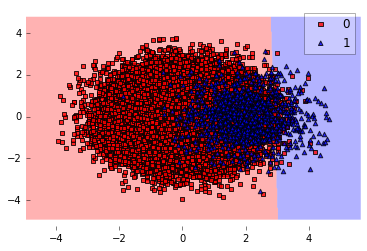

In [226]:
# Polt decision boundary
from mlxtend.plotting import plot_decision_regions

for c in [1e2]:
    clf = DT(max_depth=3)
    clf = KNN(n_neighbors=7)
    clf = LR(C=1e1)
    #clf = SVM()
    clf.fit(train_x, train_y)
    plot_decision_regions(train_x, train_y.astype('int32'), clf=clf, legend=1)
    plt.show()

In [210]:
weights = np.load('gaussian_weight.npy')
area = np.pi*4
plt.scatter(train_major_x[:, 0], train_major_x[:, 1], c='r', marker='o', s=area, edgecolors='w')
plt.scatter(train_minor_x[:, 0], train_minor_x[:, 1], c='g', marker='d', s=area, edgecolors='w')

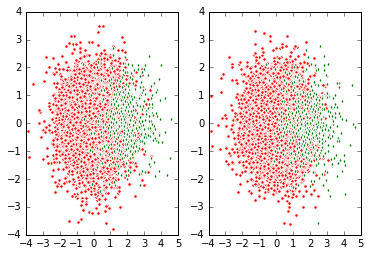

In [221]:
idxes = weights == 1
x = train_x[idxes]
y = train_y[idxes]
plt.subplot(1, 2, 1)
area = np.pi*4
plt.scatter(x[y==0][:, 0], x[y==0][:, 1], c='r', marker='o', s=area, edgecolors='w')
plt.scatter(x[y==1][:, 0], x[y==1][:, 1], c='g', marker='d', s=area, edgecolors='w')
plt.axis([-4, 5, -4, 4])
plt.subplot(1, 2, 2)
plt.scatter(train_major_x[:5272][:, 0], train_major_x[:5272][:, 1], c='r', marker='o', s=area, edgecolors='w')
plt.scatter(train_minor_x[:401][:, 0], train_minor_x[:401][:, 1], c='g', marker='d', s=area, edgecolors='w')
plt.axis([-4, 5, -4, 4])
plt.show()

In [218]:
print (y==1).sum()
print (y==0).sum()

401
5272


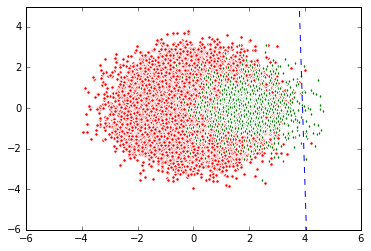

In [161]:
w0 = 0.3350000011
w1 = 0.00771287673232
b = -1.31096107019
x = np.arange(-6, 6, 0.01)
y = -(w0*x+b)/w1
area = np.pi*4
plt.scatter(train_major_x[:, 0], train_major_x[:, 1], c='r', marker='o', s=area, edgecolors='w')
plt.scatter(train_minor_x[:, 0], train_minor_x[:, 1], c='g', marker='d', s=area, edgecolors='w')
plt.plot(x, y, '--')
plt.axis([-6, 6, -6, 5])
plt.show()

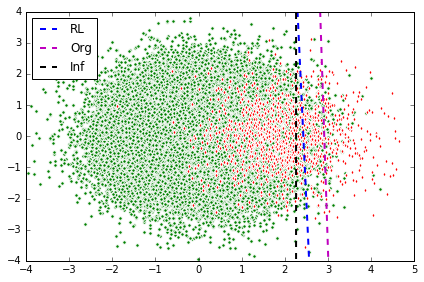

In [209]:
w0 = 1.81859824
w1 = 0.06095321
b = -4.41716709
x = np.arange(-6, 6, 0.01)
y = -(w0*x+b)/w1
area = np.pi*4
plt.scatter(train_major_x[:, 0], train_major_x[:, 1], c='g', marker='o', s=area, edgecolors='w')
plt.scatter(train_minor_x[:, 0], train_minor_x[:, 1], c='r', marker='d', s=area, edgecolors='w')
plt.plot(x, y, '--', label='RL', linewidth=2)

w0 =  2.0698549 # 2.01147662
w1 = 0.04877087 #0.09978024
b = -6.02996155 #-5.92195387
x = np.arange(-6, 6, 0.01)
y = -(w0*x+b)/w1
plt.plot(x, y, '--', c='m', label='Org', linewidth=2)

plt.legend(loc='upper left')
x = np.array([2.26]*len(x))
y = np.arange(-6, 6, 0.01)
plt.plot(x, y, '--', c='k', label='Inf', linewidth=2)
plt.legend(loc='upper left')
plt.axis([-4, 5, -4, 4])
#plt.title('Class boundaries determined by no-sampling method with SVMs')
plt.tight_layout()
plt.savefig('gaussian_boundary.pdf')
plt.show()

In [25]:
# Deal with over-sampling
from collections import Counter
from imblearn.over_sampling import SMOTE 

for i in range(1000, 5000, 500):
    sm = SMOTE(ratio={0.:25000, 1.:i}, random_state=42)
    train_x_res, train_y_res = sm.fit_sample(train_x, train_y)
    pickle.dump({'x':train_x_res, 'y':np.eye(2)[train_y_res.astype('int32')]}, open('../data/gaussian/train.pkl', 'wb+'))
    print('Resampled dataset shape {}'.format(Counter(train_y_res)))
    clf_res = MLP(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    clf_res.fit(train_x_res, train_y_res) 
    preds = clf_res.predict(valid_x)
    evaluate_f1(valid_y, preds, pos_label=1)
    preds = clf_res.predict(test_x)
    evaluate_f1(test_y, preds, pos_label=1)

Resampled dataset shape Counter({0.0: 25000, 1.0: 3000})
precision:[0.98957243 0.36404834] recall:[0.98316 0.482  ] F1: [0.98635579 0.41480207]
precision:[0.98932571 0.34866469] recall:[0.98244 0.47   ] F1: [0.98587083 0.40034072]


In [119]:
# Deal with down-sampling
from imblearn.under_sampling import (NearMiss, RandomUnderSampler, EditedNearestNeighbours, 
                                     CondensedNearestNeighbour,
                                     RepeatedEditedNearestNeighbours, AllKNN)
from imblearn.pipeline import make_pipeline
from collections import Counter

nm = NearMiss(random_state=42, version=3)
rus = RandomUnderSampler(random_state=42)
enn = RepeatedEditedNearestNeighbours(random_state=42)

Resampled dataset shape Counter({0.0: 20000, 1.0: 1000})
precision:[ 0.98766687  0.47037037] recall:[ 0.99142  0.381  ] F1: [ 0.98953987  0.42099448]
precision:[ 0.98657611  0.41213654] recall:[ 0.9907  0.326 ] F1: [ 0.98863376  0.36404243]
precision:[ 0.98661408  0.41102757] recall:[ 0.9906  0.328 ] F1: [ 0.98860302  0.36484983]


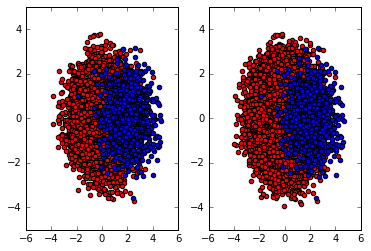

In [137]:
# Deal with down-sampling for KNN
# rus: 20000:1000 (0.417, 0.362, 0.351)
# enn: 1000:1000 (0.264, 0.238, 0.239)
rus = RandomUnderSampler(random_state=1, ratio={0:20000, 1:1000})
train_x_rus, train_y_rus = rus.fit_sample(train_x, train_y)
print('Resampled dataset shape {}'.format(Counter(train_y_rus)))
clf_res = KNN(n_neighbors=7)
clf_res.fit(train_x_rus, train_y_rus)
preds = clf_res.predict(train_x)
evaluate_f1(train_y, preds)
preds = clf_res.predict(valid_x)
evaluate_f1(valid_y, preds)
preds = clf_res.predict(test_x)
evaluate_f1(test_y, preds)
plt.subplot(1, 2, 1)
plt.scatter(train_x_rus[train_y_rus==0][:, 0], train_x_rus[train_y_rus==0][:, 1], c='r')
plt.scatter(train_x_rus[train_y_rus==1][:, 0], train_x_rus[train_y_rus==1][:, 1], c='b')
plt.subplot(1, 2, 2)
plt.scatter(train_x[train_y==0][:, 0], train_x[train_y==0][:, 1], c='r')
plt.scatter(train_x[train_y==1][:, 0], train_x[train_y==1][:, 1], c='b')
plt.show()

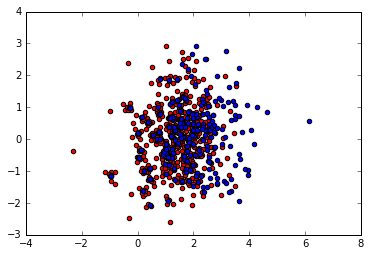

In [78]:
nm = CondensedNearestNeighbour(random_state=42)
train_x_nm, train_y_nm = nm.fit_sample(train_x, train_y)
plt.scatter(train_x_nm[train_y_nm==0][:, 0], train_x_nm[train_y_nm==0][:, 1], c='r')
plt.scatter(train_x_nm[train_y_nm==1][:, 0], train_x_nm[train_y_nm==1][:, 1], c='b')
plt.show()

In [ ]:
'AllKNN (0.3788) ~= RepeatedEditedNearestNeighbours (0.38)> EditedNearestNeighbours (0.36) > 
'CondensedNearestNeighbour (0.33) >random sample (0.30) > near miss'

In [90]:
# Combine under-sampling and up-sampling (0.389)
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
for i in [500]:
    smote_enn = SMOTEENN(random_state=42, ratio={0.:10000, 1.:i})
    X_resampled, y_resampled = smote_enn.fit_sample(train_x, train_y)
    print(sorted(Counter(y_resampled).items()))
    clf_res = MLP(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    clf_res.fit(X_resampled, y_resampled)
    preds = clf_res.predict(test_x)
    precision, recall, f1, accuracy = evaluate(test_y, preds)
    print('precision:{} recall:{} F1: {}'.format(precision, recall, f1))
    print('accuracy: {0}'.format(accuracy))
    smote_tomek = SMOTETomek(random_state=42, ratio={0.:10000, 1.:i})
    X_resampled, y_resampled = smote_tomek.fit_sample(train_x, train_y)
    print(sorted(Counter(y_resampled).items()))
    clf_res.fit(X_resampled, y_resampled)
    preds = clf_res.predict(test_x)
    precision, recall, f1, accuracy = evaluate(test_y, preds)
    print('precision:{} recall:{} F1: {}'.format(precision, recall, f1))
    print('accuracy: {0}'.format(accuracy))

[(0.0, 9439), (1.0, 170)]
precision:[0.98723574 0.41860465] recall:[0.99 0.36] F1: [0.98861594 0.38709677]
accuracy: 0.977647058824
[(0.0, 9871), (1.0, 371)]
precision:[0.98638306 0.45323741] recall:[0.9924 0.315 ] F1: [0.98938238 0.37168142]
accuracy: 0.979117647059


In [97]:
# Deal with ensemble method
from imblearn.ensemble import BalancedBaggingClassifier
clf = MLP(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
pipline = make_pipeline(RepeatedEditedNearestNeighbours(random_state=42), clf)
bbc = BalancedBaggingClassifier(base_estimator=pipline, n_estimators=20)
bbc.fit(train_x, train_y)
preds = bbc.predict(test_x)
precision, recall, f1, accuracy = evaluate(test_y, preds)
print('precision:{} recall:{} F1: {}'.format(precision, recall, f1))
print('accuracy: {0}'.format(accuracy))

precision:[0.99389591 0.16589327] recall:[0.9281 0.715 ] F1: [0.95987176 0.2693032 ]
accuracy: 0.923921568627
